In [1]:
# dataset: https://download.pytorch.org/tutorial/data.zip

In [2]:
import io
import os
import unicodedata
import string
import glob
import torch
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

c:\python36\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

In [4]:
def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []

    def find_files(path):
        return glob.glob(path)

    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]

    for filename in find_files(r"C:\Users\91830\Downloads\data (1)\data\names\*.txt"):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)

        lines = read_lines(filename)
        category_lines[category] = lines

    return category_lines, all_categories

In [5]:
category_lines, all_categories = load_data()

In [6]:
# Debugging print statements
print("Categories loaded:", all_categories)
for category in all_categories:
    print(f"Number of names in category '{category}': {len(category_lines[category])}")
    
# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


Categories loaded: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
Number of names in category 'Arabic': 2000
Number of names in category 'Chinese': 268
Number of names in category 'Czech': 519
Number of names in category 'Dutch': 297
Number of names in category 'English': 3668
Number of names in category 'French': 277
Number of names in category 'German': 724
Number of names in category 'Greek': 203
Number of names in category 'Irish': 232
Number of names in category 'Italian': 709
Number of names in category 'Japanese': 991
Number of names in category 'Korean': 94
Number of names in category 'Polish': 139
Number of names in category 'Portuguese': 74
Number of names in category 'Russian': 9408
Number of names in category 'Scottish': 100
Number of names in category 'Spanish': 298
Number of names in category 'Vietnamese': 73


In [7]:
letter_to_tensor('t')

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

In [8]:
class NameClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NameClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output, (hidden, cell_state) = self.lstm(input, hidden)
        output = self.fc(hidden.squeeze(0))
        output = self.softmax(output)
        return output, (hidden, cell_state)

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

category_lines, all_categories = load_data()
n_categories = len(all_categories)
n_hidden = 256
classifier = NameClassifier(N_LETTERS, n_hidden, n_categories)

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(classifier.parameters(), lr=learning_rate)

In [10]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

def train(line_tensor, category_tensor):
    hidden = classifier.init_hidden()
    classifier.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = classifier(line_tensor[i].unsqueeze(0), hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    return output, loss.item()

In [11]:
def random_training_example(category_lines, all_categories):
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]

    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor

In [12]:
current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0

    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100:.1f}% {loss:.4f} {line} / {guess} {correct}")

5000 5.0% 1.2524 Kwang  / Korean CORRECT
10000 10.0% 2.5311 Cober / French WRONG (Czech)
15000 15.0% 2.6333 Bordelon / Scottish WRONG (French)
20000 20.0% 1.0006 Connell / Irish CORRECT
25000 25.0% 2.0028 Cameron / French WRONG (Scottish)
30000 30.0% 1.3009 Chang / Vietnamese WRONG (Korean)
35000 35.0% 2.7453 Ventura / Portuguese WRONG (Italian)
40000 40.0% 0.0163 Haritopoulos / Greek CORRECT
45000 45.0% 0.0554 Baldi / Italian CORRECT
50000 50.0% 0.3180 Quang / Vietnamese CORRECT
55000 55.0% 1.2792 Isbitt / German WRONG (English)
60000 60.0% 0.9356 D'cruz / Spanish WRONG (Portuguese)
65000 65.0% 3.9801 D'amore / French WRONG (Italian)
70000 70.0% 0.4074 Cuocco / Italian CORRECT
75000 75.0% 0.1936 Trang / Vietnamese CORRECT
80000 80.0% 0.8517 Martin / French CORRECT
85000 85.0% 1.1848 Tono / Vietnamese WRONG (Japanese)
90000 90.0% 0.3520 Kattan / Arabic CORRECT
95000 95.0% 1.1596 Uesugi / Italian WRONG (Japanese)
100000 100.0% 0.3990 Pavlik / Czech CORRECT


In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = lstm.init_hidden()
        cell_state = lstm.init_cell_state()

        for i in range(line_tensor.size()[0]):
            output, hidden, cell_state = lstm(line_tensor[i], hidden, cell_state)

        guess = category_from_output(output)
        print(guess)

while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(sentence)


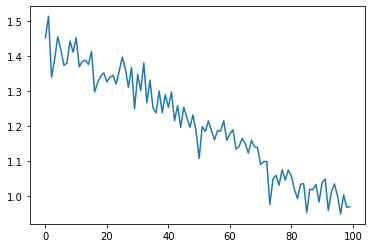

In [13]:
plt.figure()
plt.plot(all_losses)
plt.show()